# Deep Learning for Computer Vision:  HW 5

## Computer Science: COMS W 4995 006

## Due: November 10, 2022

### Problem: Telling Cats from Dogs using ResNet18

1. Here you will build a classifier that can distinguish between pictures of dogs and cats. You will use a ConvNet (Resnet18) that was pre-trained ImageNet. Your task will be to re-architect the network to solve your problem. You are required to do this in Pytorch or Tensorflow. To do this you will:

    a) Make a training, validation, and test sets for your dataset by using images from the link below, with 10,000 images of cats and 10,000 images of dogs. Use 8,000 images of each category for traning, 1,000 of each category for validation, 1,000 images of each category for testing. You are to randomly shuffle the data and choose the splits yourself.  

    b) Take ResNet18 network architecture. See https://pytorch.org/vision/stable/models.html.
    
    c) Load in the pre-trained weights. See again https://pytorch.org/vision/stable/models.html. 
    
    d) Add a fully connected layer followed by a final sigmoid layer **to replace** the last fully connected layer and 1000 category softmax layer that was used when the network was trained on ImageNet.
    
    e) Freeze all layers except the last two that you added.
    
    f) Fine-tune the network on your cats vs. dogs image data.
    
    g) Evaluate the accuracy on the test set.
    
    h) Unfreeze all layers.
    
    i) Continue fine-tuning the network on your cats vs. dogs image data.
    
    j) Evaluate the accuracy on the test set.
    
    k) Use your validation set throughout to decide on when to stop training the network at various stages.
    
    l) Comment your code and make sure to include accuracy, a few sample mistakes, and anything else you would like to add.
    
    m) Experiment with what you keep and what you replace as part of your network surgery. Does the training work better if you do not remove the last fully connected layer?
    
    n) Try this using any other CNN network you like. Take whatever path you like to get to your final model. Evaluate its accuracy. Do not ask which network you should use.


2. (Extra Credit): Repeat the assignment but replace ResNet18 with a Vision Transformer (ViT). See https://huggingface.co/docs/transformers/model_doc/vit and https://github.com/NielsRogge/Transformers-Tutorials/tree/master/VisionTransformer. 


3. (Extra Credit): Repeat the assignment but replace ResNet18 with BEiT. See https://huggingface.co/docs/transformers/model_doc/beit.

Downloads: You can get your image data from:
https://www.kaggle.com/c/dogs-vs-cats/data. 




In [ ]:
! pip install transformers datasets

In [ ]:
import glob
import numpy as np
from copy import deepcopy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
from torchvision.models import resnet18, vgg16, resnext50_32x4d
import torchvision.transforms as T

from transformers import ViTModel, BeitForImageClassification

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "/content/drive/MyDrive/Deep Learning/Datasets/catsvsdogs/train/train.zip"

In [ ]:
!ls "/content/train"

In [ ]:
# Datasets
#data_dir = './drive/MyDrive/Deep Learning/Datasets/catsvsdogs/train'
data_dir = '/content/train'
autogen_names = True
num_train = 8000
num_valid = 1000
num_test = 1000
batch_size = 100
class_names = ['cat', 'dog']

def get_class_files(class_name, num_files = 0):
  if autogen_names:
    class_files = [(data_dir + '/' + class_name + '.' + str(r) + '.jpg') for r in range(num_files)]
  else:
    class_files = glob.glob(data_dir + '/' + c + '.*.jpg')
  return class_files

class DogsVsCatsDataset(Dataset):
  def __init__(self, image_paths, crop_size = (256, 256)):
    self.image_paths = image_paths
    self.num_classes = len(self.image_paths)
    self.samples_per_class = len(self.image_paths[0])
    self.transform = T.Resize(crop_size)

  def __len__(self):
    return self.num_classes * self.samples_per_class

  def __getitem__(self, idx):
    # Get the class number corresponding to the requested index
    n_class = int(idx % self.num_classes)

    # Get the index within the class
    idx_in_class = int((idx - n_class) / self.num_classes)

    # Retrieve the image path
    image_path = self.image_paths[n_class][idx_in_class]
    
    # Load the image
    image = self.transform(read_image(image_path)).to(torch.float32)

    # Done (note that the label is the class number)
    return image, n_class

# Get the total count
num_total = num_train + num_valid + num_test

# Get the number of files to load per class
num_samples = num_total + 1
for c in class_names:
    # Get all image paths for this class
    class_files = get_class_files(c, num_total)

    # Determine how many files to include in the dataset
    num_samples_class = min(len(class_files), num_total)
    if num_samples_class < num_samples:
      num_samples = num_samples_class

# Get the sample count for the test set
percent_split = num_test / num_total
num_samples_target = (percent_split * num_samples) // 1
test_n = int((num_samples_target // batch_size) * batch_size)

# Get the sample count for the validation set
percent_split = num_valid / num_total
num_samples_target = (percent_split * num_samples) // 1
valid_n = int((num_samples_target // batch_size) * batch_size)

# Get the sample count for the training set
num_samples_target = num_samples - valid_n - test_n
train_n = int((num_samples_target // batch_size) * batch_size)

# List of file names
train_files = []
valid_files = []
test_files = []

# Loop over each class name
for c in class_names:
  # Get all image paths for this class
  class_files = np.array(get_class_files(c, num_total))

  # Generate the indices for the training, validation, and testing sets
  n = len(class_files)
  test_idx = np.random.choice(np.arange(n), test_n, replace = False) 
  remain_idx = [x for x in np.arange(n) if x not in test_idx]
  valid_idx = np.random.choice(remain_idx, valid_n, replace = False) 
  train_idx = [x for x in remain_idx if x not in valid_idx]
  
  # Add to the list of files for each set
  train_files.append(class_files[train_idx])
  valid_files.append(class_files[valid_idx])
  test_files.append(class_files[test_idx])

# Create datasets at default 256 x 256 scale
dataset_train = DogsVsCatsDataset(train_files)
dataset_valid = DogsVsCatsDataset(valid_files)
dataset_test = DogsVsCatsDataset(test_files)

# Create datasets at 224 x 224 scale 
dataset_train_224 = DogsVsCatsDataset(train_files, crop_size=(224, 224))
dataset_valid_224 = DogsVsCatsDataset(valid_files, crop_size=(224, 224))
dataset_test_224 = DogsVsCatsDataset(test_files, crop_size=(224, 224))

# Check lengths
print('Dataset sizes:')
print(f'- {len(dataset_train):d} training')
print(f'- {len(dataset_valid):d} validation')
print(f'- {len(dataset_test):d} testing')

Dataset sizes:
- 16000 training
- 2000 validation
- 2000 testing


Networks used in this assignment

In [ ]:
# Customized ResNet18
class CustomPretrainedNN(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return self.added_layers(self.model(x))
    
  def get_trainable_parameters(self):
    # Return the trainable (unfrozen) parameters
    trainable_params = []
    for model in [self.model, self.added_layers]:
      for param in model.parameters():
        if param.requires_grad == True: trainable_params.append(param)
    return trainable_params

  def freeze(self):
    for model in [self.model, self.added_layers]:
      for param in model.parameters():
        param.requires_grad = False
  
  def unfreeze(self):
    for model in [self.model, self.added_layers]:
      for param in model.parameters():
        param.requires_grad = True

class ResNet18_Custom_ReplaceFC(CustomPretrainedNN):
  def __init__(self):
    super().__init__()

    # Load the pre-trained ResNet18 and freeze its parameters
    self.model = resnet18()
    self.added_layers = nn.Identity()
    self.freeze()
    
    # Replace the last fully connected layer (512 x 1000) with a 512 x 2 one
    self.model.fc = nn.Linear(512, 2)

    # Follow this with a sigmoid
    self.added_layers = nn.Sequential(nn.Sigmoid())

class ResNet18_Custom_AddFC(CustomPretrainedNN):
  def __init__(self):
    super().__init__()

    # Load the pre-trained ResNet18 and freeze its parameters
    self.model = resnet18()
    self.added_layers = nn.Identity()
    self.freeze()
    
    # Add a fully connected last layer (1000 X 2) followed by a sigmoid
    self.added_layers = nn.Sequential(nn.Linear(1000, 2), nn.Sigmoid())

class VGG16_Custom(CustomPretrainedNN):
  def __init__(self):
    super().__init__()

    # Load the pre-trained VGG16 and freeze its parameters
    self.model = vgg16()
    self.added_layers = nn.Identity()
    self.freeze()
    
    # Replace the last linear layer (4096 x 1000) with a 4096 x 2 one
    self.model.classifier[6] = nn.Linear(4096, 2)

class ViT_Custom(CustomPretrainedNN):
  def __init__(self):
    super().__init__()

    # Load the pre-trained VGG16 and freeze its parameters
    self.model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
    self.added_layers = nn.Identity()
    self.freeze()
    
    # Make the last layer 768 x 2
    self.model.pooler.dense = nn.Linear(768, 2)

  def forward(self, x):
    return self.added_layers(self.model(x))[1]

class BEiT_Custom(CustomPretrainedNN):
  def __init__(self):
    super().__init__()

    # Load the pre-trained VGG16 and freeze its parameters
    self.model = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224")
    self.added_layers = nn.Identity()
    self.freeze()
    
    # Make the last layer 768 x 2
    self.model.classifier = nn.Linear(768, 2)

  def forward(self, x):
    return self.added_layers(self.model(x)).logits

Network components

In [20]:
# Loss functions
loss_fn_bce = torch.nn.BCELoss()
loss_fn_ce = torch.nn.CrossEntropyLoss()

# Accuracy calculation
def accuracy_calc(labels_pred, labels_true):
  pred_class = torch.argmax(torch.Tensor(labels_pred), 1)
  true_class = torch.argmax(torch.Tensor(labels_true), 1)
  correct_predictions = torch.eq(pred_class, torch.Tensor(true_class)) 
  return 100 * torch.mean(torch.Tensor.to(correct_predictions, dtype = torch.float32)).cpu()

# Helper function to format the output labels as a one-hot tensor
def format_labels(labels_vector, format_like):
  labels = torch.zeros_like(format_like)
  for r in range(len(labels_vector)):
    labels[r][labels_vector[r]] = 1.0
  return labels

# Evaluate the model
def eval_model(model, loader, loss_fn = loss_fn_bce):
  # Evaluation mode
  model.eval()
  with torch.no_grad():
    loss_list = []
    acc_list = []

    # Proceed by batch
    for images, labels_vector in loader:
      # Predict
      pred_labels = model(images.to(device)) 

      # Format the true labels
      true_labels = format_labels(labels_vector, pred_labels).to(device)

      # Evaluate accuracy and loss
      acc_list.append(accuracy_calc(pred_labels, true_labels))
      loss_list.append(loss_fn(pred_labels, true_labels).cpu().item())

      # Clear cache
      if (device.type == 'cuda'):
        with torch.no_grad():
          torch.cuda.empty_cache()

  # Return accuracy and loss, averaged across batches
  return np.mean(acc_list), np.mean(loss_list)

# Model training and validation
def train_model(model, num_epochs = 25, batch_size = 100, learning_rate = 0.1, 
                loss_fn = loss_fn_bce, crop_size = (256, 256),
                ds_train = dataset_train, ds_valid = dataset_valid):
  
  # Record the best model
  best_model = deepcopy(model)
  best_valid_acc = 0
  best_valid_loss = 0

  # Return if no epochs
  if num_epochs < 1: return best_model

  # Number of training batches
  num_training_batches = int(np.ceil(len(dataset_train) / batch_size))

  # Use an SGD optimizer (unfrozen parameters only)
  try:
    optimizer = torch.optim.SGD(model.get_trainable_parameters(), learning_rate)
  except:
    optimizer = torch.optim.SGD(model.parameters(), learning_rate)

  # Create data loaders
  loader_train = DataLoader(ds_train, batch_size, shuffle = True)
  loader_valid = DataLoader(ds_valid, batch_size, shuffle = True)

  # Epochs
  for e in range(num_epochs):
    # Training
    model.train()
    #b = 0
    for train_images, train_labels_vector in loader_train:
      # Reset the gradients
      optimizer.zero_grad()

      # Predict
      train_pred_labels = model(train_images.to(device))
      # Format the true labels
      train_labels = format_labels(train_labels_vector, train_pred_labels).to(device)

      # Compute accuracy and loss
      train_acc = accuracy_calc(train_pred_labels, train_labels)
      train_loss = loss_fn(train_pred_labels, train_labels)
      
      # Back-propagate
      train_loss.backward()

      # Update parameters
      optimizer.step()

      # Progress
      #b += 1
      #print(f'- Training batch {b:d} of {num_training_batches:d}: accuracy {train_acc:.1f}%, loss {train_loss:f}', end='\r')

      # Clear cache
      if (device.type == 'cuda'):
        with torch.no_grad():
          torch.cuda.empty_cache()
      
    # Validation
    valid_acc, valid_loss = eval_model(model, loader_valid, loss_fn = loss_fn)
    print(f'Epoch {e+1:d} of {num_epochs:d}: validation accuracy {valid_acc:.1f}%, validation loss {valid_loss:f}')

    # Keep the current model if its validation accuracy is better
    if (valid_acc > best_valid_acc):
      best_model = deepcopy(model)
      best_valid_acc = valid_acc
      best_valid_loss = valid_loss    

  # Return
  return best_model

# Testing
def test_model(model, loss_fn = loss_fn_bce, ds_test = dataset_test):
  loader_test = DataLoader(ds_test, batch_size, shuffle = True)
  test_acc, test_loss = eval_model(model, loader_test, loss_fn = loss_fn)
  print(f'Testing: accuracy {test_acc:.1f}%, loss {test_loss:f}')

def plot_miss_examples(model, loss_fn = loss_fn_bce, crop_size =( 256, 256), 
                       num_examples_max = 5):
  for c in range(len(class_names)):
    num_examples = 0
    for f in test_files[c]:
      # Load and test this tile
      dataset_miss = DogsVsCatsDataset([[f]], crop_size = crop_size)
      loader_miss = DataLoader(dataset_miss)
      acc, _ = eval_model(model, loader_miss, loss_fn = loss_fn)

      # Plot if misclassified
      if acc < 100:
        plt.imshow(mpimg.imread(f))
        plt.title(f)
        plt.axis('off')
        plt.show()
        num_examples += 1

      # Move to the next example if the maximum number have been reached
      if num_examples >= num_examples_max: break

def demonstrate_model(model, loss_fn = loss_fn_bce, num_epochs = 25, use_224_ds = False):
    # Datasets
    if use_224_ds:
      ds_train = dataset_train_224
      ds_valid = dataset_valid_224
      ds_test = dataset_test_224
      crop_size = (224, 224)
    else:
      ds_train = dataset_train
      ds_valid = dataset_valid
      ds_test = dataset_test
      crop_size = (256, 256)
    
    # Send model to GPU
    model.to(device)

    # Train last layer of model and test
    print('Training added layers only (pre-trained portion frozen)')
    model = train_model(model, num_epochs = num_epochs, loss_fn = loss_fn, 
                        ds_train = ds_train, ds_valid = ds_valid)
    test_model(model, loss_fn = loss_fn, ds_test = ds_test)

    # Unfreezs, train more, and test again
    print('Training all layers (pre-trained portion unfrozen)')
    model.unfreeze()
    model = train_model(model, num_epochs = num_epochs, loss_fn = loss_fn, 
                        ds_train = ds_train, ds_valid = ds_valid)
    test_model(model, loss_fn = loss_fn, ds_test = ds_test)

    # Plot a few misses
    print('Example misses')
    plot_miss_examples(model, loss_fn = loss_fn, crop_size = crop_size)

    # Done
    return model

ResNet18 with the last fully connected layer replaced and a sigmoid added at the end

Final accuracy achieved: 84.6%

Training added layers only (pre-trained portion frozen)
Epoch 1 of 25: validation accuracy 50.0%, validation loss 2.028378
Epoch 2 of 25: validation accuracy 52.3%, validation loss 1.124883
Epoch 3 of 25: validation accuracy 55.5%, validation loss 1.138515
Epoch 4 of 25: validation accuracy 55.1%, validation loss 1.033670
Epoch 5 of 25: validation accuracy 52.0%, validation loss 1.247894
Epoch 6 of 25: validation accuracy 60.8%, validation loss 0.885112
Epoch 7 of 25: validation accuracy 50.7%, validation loss 1.834811
Epoch 8 of 25: validation accuracy 56.5%, validation loss 1.013819
Epoch 9 of 25: validation accuracy 51.2%, validation loss 1.500369
Epoch 10 of 25: validation accuracy 51.0%, validation loss 1.627461
Epoch 11 of 25: validation accuracy 50.8%, validation loss 1.616808
Epoch 12 of 25: validation accuracy 50.7%, validation loss 1.840328
Epoch 13 of 25: validation accuracy 61.5%, validation loss 0.807277
Epoch 14 of 25: validation accuracy 53.2%, validation loss 1.196937
E

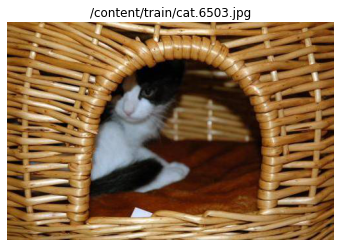

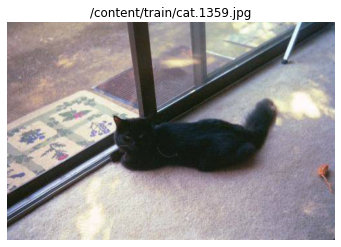

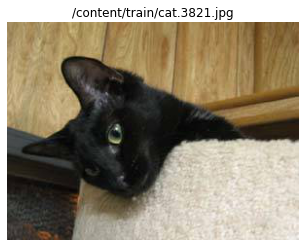

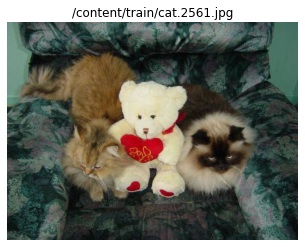

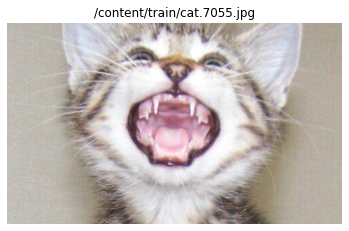

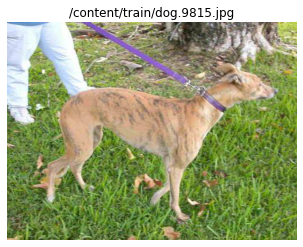

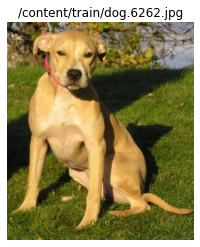

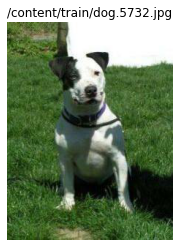

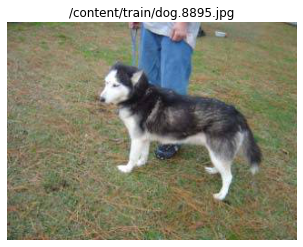

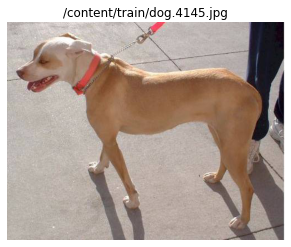

In [ ]:
model_r18 = ResNet18_Custom_ReplaceFC()
model_r18_final = demonstrate_model(model_r18)

ResNet18 with the last fully connected layer kept, followed by another fully connected layer and a sigmoid

Final accuracy achieved: 91.2%

Training added layers only (pre-trained portion frozen)
Epoch 1 of 25: validation accuracy 50.5%, validation loss 0.873865
Epoch 2 of 25: validation accuracy 50.8%, validation loss 0.914824
Epoch 3 of 25: validation accuracy 52.3%, validation loss 0.810028
Epoch 4 of 25: validation accuracy 51.0%, validation loss 0.939827
Epoch 5 of 25: validation accuracy 63.0%, validation loss 0.644616
Epoch 6 of 25: validation accuracy 64.1%, validation loss 0.656284
Epoch 7 of 25: validation accuracy 52.3%, validation loss 0.884010
Epoch 8 of 25: validation accuracy 61.5%, validation loss 0.647852
Epoch 9 of 25: validation accuracy 53.5%, validation loss 0.864006
Epoch 10 of 25: validation accuracy 54.2%, validation loss 0.796688
Epoch 11 of 25: validation accuracy 63.8%, validation loss 0.661849
Epoch 12 of 25: validation accuracy 58.0%, validation loss 0.714131
Epoch 13 of 25: validation accuracy 63.1%, validation loss 0.659635
Epoch 14 of 25: validation accuracy 53.9%, validation loss 0.836300
E

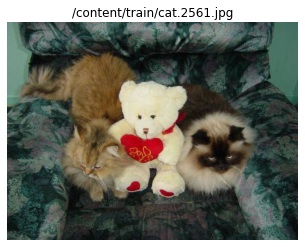

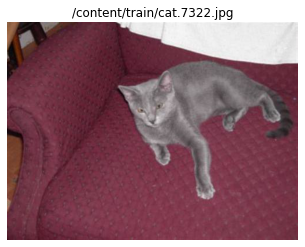

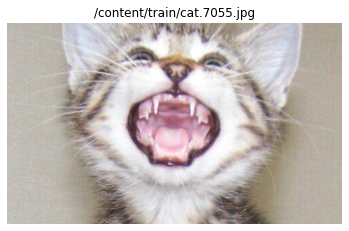

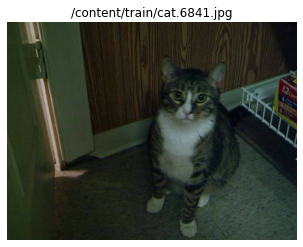

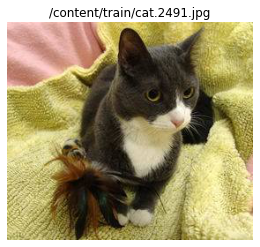

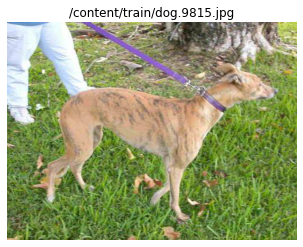

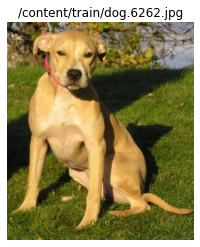

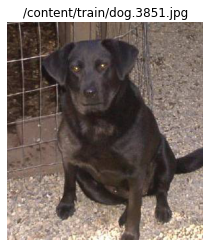

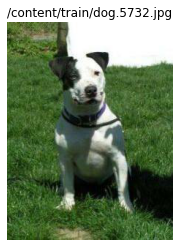

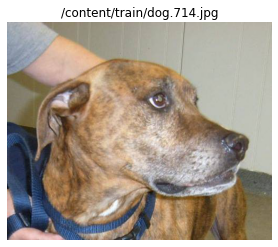

In [23]:
model_r18_alt = ResNet18_Custom_AddFC()
model_r18_alt_final = demonstrate_model(model_r18_alt)

Using another CNN: VGG16 with a modified last layer

Final accuracy achieved: 50.0%

In [ ]:
model_vgg = VGG16_Custom()
model_vgg_final = demonstrate_model(model_vgg, num_epochs = 25, loss_fn = loss_fn_ce)

Training added layers only (pre-trained portion frozen)
Epoch 1 of 25: validation accuracy 50.0%, validation loss 6555.925073
Epoch 2 of 25: validation accuracy 50.0%, validation loss 6502.414551
Epoch 3 of 25: validation accuracy 50.1%, validation loss 2446.425867
Epoch 4 of 25: validation accuracy 50.8%, validation loss 1834.118304
Epoch 5 of 25: validation accuracy 50.7%, validation loss 2337.021301
Epoch 6 of 25: validation accuracy 50.0%, validation loss 3335.265527
Epoch 7 of 25: validation accuracy 62.8%, validation loss 754.670515
Epoch 8 of 25: validation accuracy 56.0%, validation loss 1480.397083
Epoch 9 of 25: validation accuracy 61.2%, validation loss 826.586722
Epoch 10 of 25: validation accuracy 62.5%, validation loss 722.072649
Epoch 11 of 25: validation accuracy 62.5%, validation loss 818.721729
Epoch 12 of 25: validation accuracy 60.8%, validation loss 1055.572781
Epoch 13 of 25: validation accuracy 55.8%, validation loss 1356.861691
Epoch 14 of 25: validation accurac

ViT from HuggingFace

Final accuracy achieved: 72.3%

Training added layers only (pre-trained portion frozen)
Epoch 1 of 25: validation accuracy 58.8%, validation loss 0.667198
Epoch 2 of 25: validation accuracy 61.8%, validation loss 0.654031
Epoch 3 of 25: validation accuracy 62.5%, validation loss 0.648433
Epoch 4 of 25: validation accuracy 63.3%, validation loss 0.640107
Epoch 5 of 25: validation accuracy 64.2%, validation loss 0.635293
Epoch 6 of 25: validation accuracy 64.2%, validation loss 0.631058
Epoch 7 of 25: validation accuracy 64.8%, validation loss 0.627773
Epoch 8 of 25: validation accuracy 65.3%, validation loss 0.624946
Epoch 9 of 25: validation accuracy 65.5%, validation loss 0.623513
Epoch 10 of 25: validation accuracy 65.6%, validation loss 0.620811
Epoch 11 of 25: validation accuracy 65.9%, validation loss 0.619819
Epoch 12 of 25: validation accuracy 66.2%, validation loss 0.615356
Epoch 13 of 25: validation accuracy 67.0%, validation loss 0.613863
Epoch 14 of 25: validation accuracy 67.1%, validation loss 0.612244
E

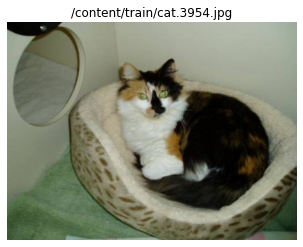

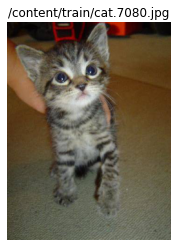

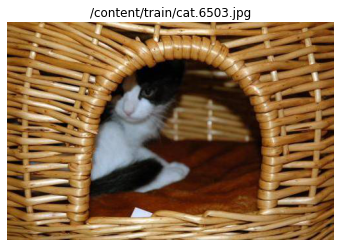

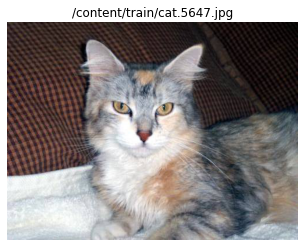

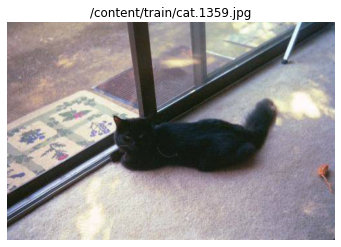

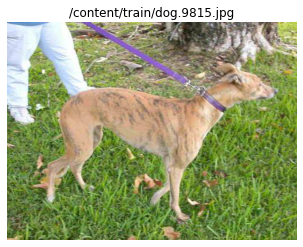

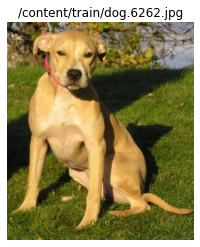

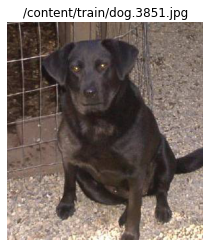

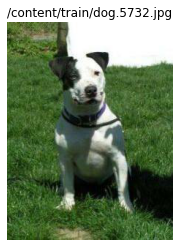

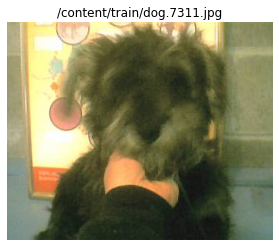

In [21]:
model_vit = ViT_Custom()
model_vit_final = demonstrate_model(model_vit, loss_fn = loss_fn_ce, use_224_ds = True)

BEiT from HuggingFace

Final accuracy achieved: 53.5%

Training added layers only (pre-trained portion frozen)
Epoch 1 of 25: validation accuracy 50.0%, validation loss 45.795448
Epoch 2 of 25: validation accuracy 50.4%, validation loss 22.605908
Epoch 3 of 25: validation accuracy 50.2%, validation loss 38.292471
Epoch 4 of 25: validation accuracy 50.4%, validation loss 47.757019
Epoch 5 of 25: validation accuracy 50.8%, validation loss 41.520110
Epoch 6 of 25: validation accuracy 50.5%, validation loss 46.541548
Epoch 7 of 25: validation accuracy 50.8%, validation loss 40.493490
Epoch 8 of 25: validation accuracy 52.2%, validation loss 30.890823
Epoch 9 of 25: validation accuracy 50.4%, validation loss 50.752494
Epoch 10 of 25: validation accuracy 52.2%, validation loss 31.084479
Epoch 11 of 25: validation accuracy 51.8%, validation loss 34.150026
Epoch 12 of 25: validation accuracy 51.8%, validation loss 20.514216
Epoch 13 of 25: validation accuracy 50.0%, validation loss 50.889677
Epoch 14 of 25: validation accuracy 55.3%, validation lo

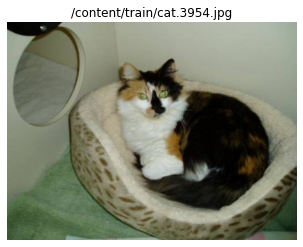

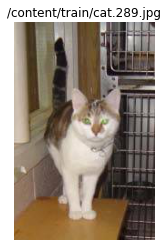

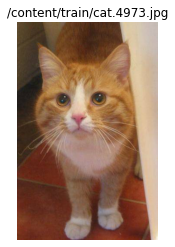

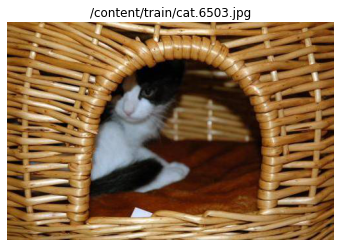

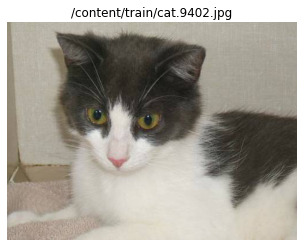

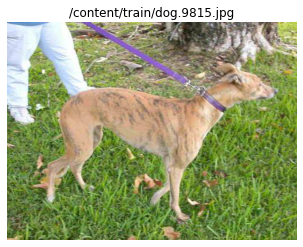

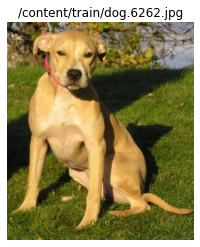

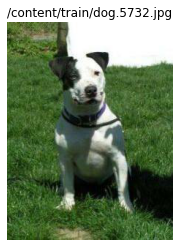

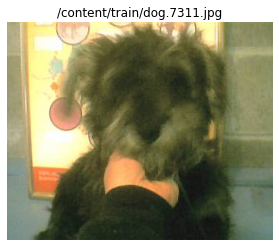

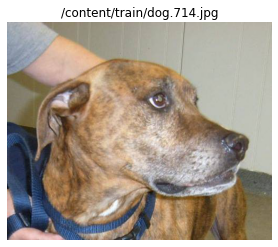

In [22]:
model_beit = BEiT_Custom()
model_beit = demonstrate_model(model_beit, loss_fn = loss_fn_ce, use_224_ds = True)